## Imports

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
from nltk.corpus import movie_reviews
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import AdamW
import torch
from torch.utils.data import Dataset, DataLoader




## Baixar Recursos Necessários

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('movie_reviews')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\phkil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\phkil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\phkil\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


True

## Criar lista, texto/sentimento


In [4]:
documentos = [
    (' '.join(movie_reviews.words(fileid)), category)
    for category in movie_reviews.categories()
    for fileid in movie_reviews.fileids(category)
]
# Transformar em dataframe
df = pd.DataFrame(documentos, columns=['texto', 'sentimento'])
df.head

<bound method NDFrame.head of                                                   texto sentimento
0     plot : two teen couples go to a church party ,...        neg
1     the happy bastard ' s quick movie review damn ...        neg
2     it is movies like these that make a jaded movi...        neg
3     " quest for camelot " is warner bros . ' first...        neg
4     synopsis : a mentally unstable man undergoing ...        neg
...                                                 ...        ...
1995  wow ! what a movie . it ' s everything a movie...        pos
1996  richard gere can be a commanding actor , but h...        pos
1997  glory -- starring matthew broderick , denzel w...        pos
1998  steven spielberg ' s second epic film on world...        pos
1999  truman ( " true - man " ) burbank is the perfe...        pos

[2000 rows x 2 columns]>

## Processamento de texto

### Configurações de pré-processamento

In [5]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

### Função de processamento com remoção de números

In [6]:
def preprocessar_texto_remover_numeros(texto):
    texto = texto.lower()
    texto = re.sub(r'[^a-z\s]', '', texto)
    tokens = texto.split()
    tokens = [p for p in tokens if p not in stop_words]
    tokens = [stemmer.stem(p) for p in tokens]
    return tokens

def preprocessar_texto_mantendo_numeros(texto):
    texto = texto.lower()
    # permite dígitos além de letras e espaços
    texto = re.sub(r'[^a-z0-9\s]', '', texto)
    # usar split() para tokenizar; isto preserva números sem usar 'punkt'
    tokens = texto.split()
    tokens = [p for p in tokens if p not in stop_words]
    tokens = [stemmer.stem(p) for p in tokens]
    return tokens

### Contagem de sentimentos

In [7]:
contagem = df['sentimento'].value_counts()
print(f"Distribuição de sentimentos: {contagem}")

Distribuição de sentimentos: sentimento
neg    1000
pos    1000
Name: count, dtype: int64


### Vizualização

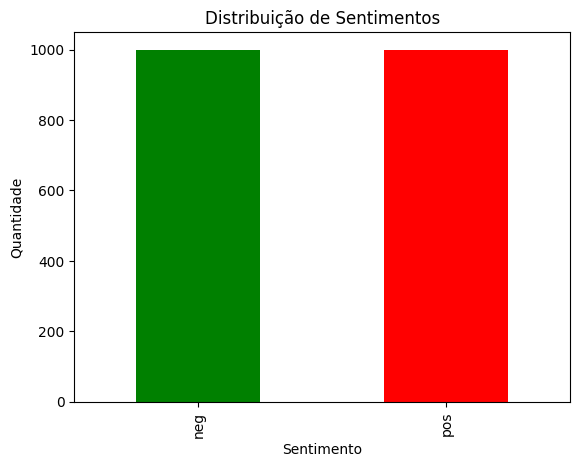

In [8]:
contagem.plot(kind='bar', color=['green', 'red'])
plt.title("Distribuição de Sentimentos")
plt.xlabel("Sentimento")
plt.ylabel("Quantidade")
plt.show()

## TF - IDF E BAG OF WORDS

In [9]:
# Aplicando pré-processamento
df['tokens'] = df['texto'].apply(preprocessar_texto_mantendo_numeros)

# Transformando tokens em string novamente para o vetorizer
df['texto_limpo'] = df['tokens'].apply(lambda lista: ' '.join(lista))

# BAG OF WORDS
vectorizer_bow = CountVectorizer()
X_bow = vectorizer_bow.fit_transform(df['texto_limpo'])

print("Matriz Bag of Words:")
print(X_bow.toarray())
print("\nFormato da matriz:", X_bow.toarray().shape)

# TF-IDF
vectorizer_tfidf = TfidfVectorizer()
X_tfidf = vectorizer_tfidf.fit_transform(df['texto_limpo'])

print("\nMatriz TF-IDF:")
print(X_tfidf.toarray())
print("\nFormato da matriz:", X_tfidf.toarray().shape)

Matriz Bag of Words:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Formato da matriz: (2000, 25780)

Matriz TF-IDF:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Formato da matriz: (2000, 25780)


### Análise dos resultados

In [10]:
vocab = vectorizer_bow.get_feature_names_out()
len(vocab)
print(vocab[:50])   
idf = vectorizer_tfidf.idf_
top_10_raras = sorted(zip(vocab, idf), key=lambda x: -x[1])[:10]
top_10_comuns = sorted(zip(vocab, idf), key=lambda x: x[1])[:10]
print("Raras:", top_10_raras)
print("Comuns:", top_10_comuns)

['00' '000' '0009f' '007' '03' '04' '05' '05425' '10' '100' '1000' '10000'
 '100m' '101' '102' '103' '104' '105' '106' '107' '108' '109' '10b' '10th'
 '11' '110' '111' '112' '113' '1138' '114' '115' '117' '118' '11th' '12'
 '121' '122' '123' '125' '126' '127' '1272' '128' '129' '1298' '12th' '13'
 '130' '1305']
Raras: [('0009f', np.float64(7.908255154023788)), ('03', np.float64(7.908255154023788)), ('04', np.float64(7.908255154023788)), ('05425', np.float64(7.908255154023788)), ('10000', np.float64(7.908255154023788)), ('104', np.float64(7.908255154023788)), ('109', np.float64(7.908255154023788)), ('10b', np.float64(7.908255154023788)), ('111', np.float64(7.908255154023788)), ('112', np.float64(7.908255154023788))]
Comuns: [('film', np.float64(1.104195111380416)), ('one', np.float64(1.1114314357489328)), ('movi', np.float64(1.1910552367627092)), ('like', np.float64(1.246400413478477)), ('make', np.float64(1.3220834991691133)), ('charact', np.float64(1.331785584975564)), ('time', np.flo

## Treino e avaliação de modelos

### Naive Bayes

In [11]:

labels = df["sentimento"]

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, labels, test_size=0.33, random_state=42
)

modelo = MultinomialNB(alpha=0.2, fit_prior=False)
modelo.fit(X_train, y_train)


y_pred = modelo.predict(X_test)
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de classificação:\n", classification_report(y_test, y_pred))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred))

Acurácia: 0.7893939393939394

Relatório de classificação:
               precision    recall  f1-score   support

         neg       0.77      0.81      0.79       325
         pos       0.81      0.77      0.79       335

    accuracy                           0.79       660
   macro avg       0.79      0.79      0.79       660
weighted avg       0.79      0.79      0.79       660

Matriz de confusão:
 [[263  62]
 [ 77 258]]


### SVM

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, labels, test_size=0.33, random_state=42
)

modeloSVM = LinearSVC()
modeloSVM.fit(X_train, y_train)

y_pred = modeloSVM.predict(X_test)
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de classificação:\n", classification_report(y_test, y_pred))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred))

Acurácia: 0.8136363636363636

Relatório de classificação:
               precision    recall  f1-score   support

         neg       0.82      0.80      0.81       325
         pos       0.81      0.83      0.82       335

    accuracy                           0.81       660
   macro avg       0.81      0.81      0.81       660
weighted avg       0.81      0.81      0.81       660

Matriz de confusão:
 [[260  65]
 [ 58 277]]


### Regressão Logística

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, labels, test_size=0.33, random_state=42
)


modeloRL = LogisticRegression(
    max_iter=2000,
    solver="lbfgs",
    n_jobs=-1
)

modeloRL.fit(X_train, y_train)

y_pred = modeloRL.predict(X_test)
print("Acurácia:", accuracy_score(y_test, y_pred))
print("\nRelatório de classificação:\n", classification_report(y_test, y_pred))
print("Matriz de confusão:\n", confusion_matrix(y_test, y_pred))


Acurácia: 0.8136363636363636

Relatório de classificação:
               precision    recall  f1-score   support

         neg       0.81      0.81      0.81       325
         pos       0.81      0.82      0.82       335

    accuracy                           0.81       660
   macro avg       0.81      0.81      0.81       660
weighted avg       0.81      0.81      0.81       660

Matriz de confusão:
 [[262  63]
 [ 60 275]]


### Random Forest

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, labels, test_size=0.33, random_state=42
)

depths = [5, 10, 15, 20, 25, 30, 50, 100, None]
acuracias = []
for d in depths:
    modeloRF = RandomForestClassifier(
        n_estimators=300,    
        max_depth=d,      
        n_jobs=-1,           
        random_state=42
    )

    modeloRF.fit(X_train, y_train)

    y_pred = modeloRF.predict(X_test)
    acuracia = accuracy_score(y_test,y_pred)
    acuracias.append((d, acuracia))

for profundidade, acur in acuracias:
    print(f"Profundidade: {profundidade} - Acurcacia: {acur}")

Profundidade: 5 - Acurcacia: 0.7818181818181819
Profundidade: 10 - Acurcacia: 0.7772727272727272
Profundidade: 15 - Acurcacia: 0.7833333333333333
Profundidade: 20 - Acurcacia: 0.7787878787878788
Profundidade: 25 - Acurcacia: 0.7818181818181819
Profundidade: 30 - Acurcacia: 0.7818181818181819
Profundidade: 50 - Acurcacia: 0.7727272727272727
Profundidade: 100 - Acurcacia: 0.7833333333333333
Profundidade: None - Acurcacia: 0.7833333333333333


### DistilBERT

In [ ]:
textos = df['texto'].apply(preprocessar_texto_mantendo_numeros)
labels = labels = df["sentimento"]

# Encode Labels
le = LabelEncoder()
labels = le.fit_transform(labels)

# Split
X_train, X_test, y_train, y_test = train_test_split(
    textos, labels, test_size=0.2, random_state=42
)

# Corrige o erro de KeyError
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = pd.Series(y_train).reset_index(drop=True)
y_test = pd.Series(y_test).reset_index(drop=True)


# Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# Dataset PyTorch
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        if isinstance(text, (list, tuple)):
            text = ' '.join(map(str, text))
        else:
            text = str(text)

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


train_dataset = TextDataset(X_train, y_train, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)


# Modelo Distibert
num_labels = len(le.classes_)

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
)

optimizer = AdamW(model.parameters(), lr=5e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Treinamento do modelo

epochs = 2

for epoch in range(epochs):
    print(f"Época {epoch+1}/{epochs}")
    model.train()

    for batch in tqdm(train_loader):
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()

    print(f"Loss da época: {loss.item()}")


# Treinamento do Modelo

model.eval()
preds = []
true = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=mask
        )

        logits = outputs.logits
        batch_preds = torch.argmax(logits, dim=1).cpu().numpy()

        preds.extend(batch_preds)
        true.extend(batch["labels"].numpy())

print("\nAcurácia:", accuracy_score(true, preds))
print("\nRelatório de classificação:\n")
print(classification_report(true, preds))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Época 1/2


100%|██████████| 200/200 [18:29<00:00,  5.55s/it]


Loss da época: 0.6812878847122192
Época 2/2


100%|██████████| 200/200 [14:33<00:00,  4.37s/it]


Loss da época: 0.7011759877204895

Acurácia: 0.4975

Relatório de classificação:

              precision    recall  f1-score   support

           0       0.50      1.00      0.66       199
           1       0.00      0.00      0.00       201

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400



c:\Users\phkil\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\phkil\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\phkil\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave